<a href="https://colab.research.google.com/github/codingpotato/pill-detection/blob/master/pill_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

## Clone Pill Detection

In [0]:
!git clone https://github.com/codingpotato/pill-detection.git
!mkdir /content/pill-detection/generated_images
!mkdir /content/pill-detection/data

## Download Pre-Trained Model

In [0]:
!wget http://download.tensorflow.org/models/object_detection/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz

In [0]:
!tar xfv ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz
!mv ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt* /content/pill-detection/data

## Install Tensorflow Object Detection API

In [0]:
!git clone https://github.com/tensorflow/models.git

In [0]:
!pip install Cython
!apt-get install protobuf-compiler
!git clone https://github.com/cocodataset/cocoapi.git
!cd cocoapi/PythonAPI; make; cp -r pycocotools /content/models/research/

In [0]:
%set_env PYTHONPATH=/content/models/research:/content/models/research/slim
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

## Test Tensorflow Object Detection API

In [0]:
!python object_detection/builders/model_builder_test.py

# Prepare Images

In [0]:
data_path = '/content/pill-detection/data/'

In [0]:
from PIL import Image
from random import randint
import matplotlib.pyplot as plt

image_prefix = '/content/pill-detection/images/'
generated_image_prefix = '/content/pill-detection/generated_images/'
image_size = (300, 300)

def generate_images(name):
  for index in xrange(1, 101):
    image = Image.new('RGB', image_size, '#000')
    pill_image = Image.open(image_prefix + name + '.png')
    rotated_image = pill_image.rotate(randint(0, 359), expand=True)
    x = randint(0, image_size[0] - rotated_image.size[0])
    y = randint(0, image_size[1] - rotated_image.size[1])
    image.paste(rotated_image, (x, y))
    image.save(generated_image_prefix + name + '_' + str(index) + '.png')

In [0]:
labels = ['325', '500']
for label in labels:
  generate_images(label)

In [0]:
import cv2

def boundingRect(image):
  image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  _, image_bw = cv2.threshold(image_bw, 1, 255, cv2.THRESH_BINARY)
  _, contours, _ = cv2.findContours(image_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  max_area = 0
  x, y, w, h = (0, 0, 0, 0)
  for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > max_area:
      max_area = area
      x, y, w, h = cv2.boundingRect(cnt)
  return (x, y, w, h)

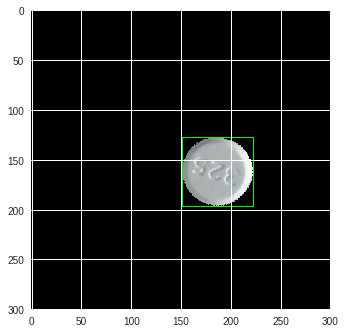

In [64]:
image = cv2.imread(generated_image_prefix + '325_31.png')
x, y, w, h = boundingRect(image)
cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
cv2.imwrite(image_prefix + 'aa.png', image)
plt.imshow(image)

# Prepare Data

## Create Label Map

In [0]:
!echo -e " \n\
item { \n\
  id: 1 \n\
  name: '325' \n\
} \n\
\n\
item { \n\
  id: 2 \n\
  name: '500' \n\
} \
" > /content/pill-detection/data/label_map.pbtxt

In [0]:
import tensorflow as tf
from object_detection.utils import dataset_util


def generate_tf_record(record_path, start, size):
  writer = tf.python_io.TFRecordWriter(record_path)
  label_index = 1
  for label in labels:
    for index in xrange(start, start + size):
      filename = generated_image_prefix + label + '_' + str(index) + '.png'
      image = cv2.imread(filename)
      x, y, w, h = boundingRect(image)
    
      image_format = b'png'
      with tf.gfile.GFile(filename, 'rb') as fid:
        encoded_png = fid.read()
      tf_example = tf.train.Example(features=tf.train.Features(feature={
          'image/height': dataset_util.int64_feature(image_size[0]),
          'image/width': dataset_util.int64_feature(image_size[1]),
          'image/filename': dataset_util.bytes_feature(filename),
          'image/source_id': dataset_util.bytes_feature(filename),
          'image/encoded': dataset_util.bytes_feature(encoded_png),
          'image/format': dataset_util.bytes_feature(image_format),
          'image/object/bbox/xmin': dataset_util.float_list_feature([x]),
          'image/object/bbox/xmax': dataset_util.float_list_feature([y]),
          'image/object/bbox/ymin': dataset_util.float_list_feature(
              [x + w - 1]),
          'image/object/bbox/ymax': dataset_util.float_list_feature(
              [y + h - 1]),
          'image/object/class/text': dataset_util.bytes_list_feature(
              [label]),
          'image/object/class/label': dataset_util.int64_list_feature(
              [label_index]),
      }))
      writer.write(tf_example.SerializeToString())
    label_index += 1
  writer.close()

In [0]:
generate_tf_record(data_path + 'train.record', 1, 70)
generate_tf_record(data_path + 'test.record', 71, 30)

# Status

In [88]:
!ls -l /content/pill-detection/data
!cat /content/pill-detection/data/label_map.pbtxt

total 23572
-rw-r--r-- 1 root   root        73 Nov 17 07:16 label_map.pbtxt
-rw-r----- 1 345018 89939 18205188 May 10  2018 model.ckpt.data-00000-of-00001
-rw-r----- 1 345018 89939    17703 May 10  2018 model.ckpt.index
-rw-r----- 1 345018 89939  3665866 May 10  2018 model.ckpt.meta
-rw-r--r-- 1 root   root    671019 Nov 17 08:23 test.record
-rw-r--r-- 1 root   root   1568411 Nov 17 08:23 train.record
 
item { 
  id: 1 
  name: '325' 
} 

item { 
  id: 2 
  name: '500' 
} 


In [69]:
!uptime

 08:19:07 up  2:29,  0 users,  load average: 0.22, 0.08, 0.02


In [0]:
!ps